# Libraries

In [2]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# I added
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedShuffleSplit

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

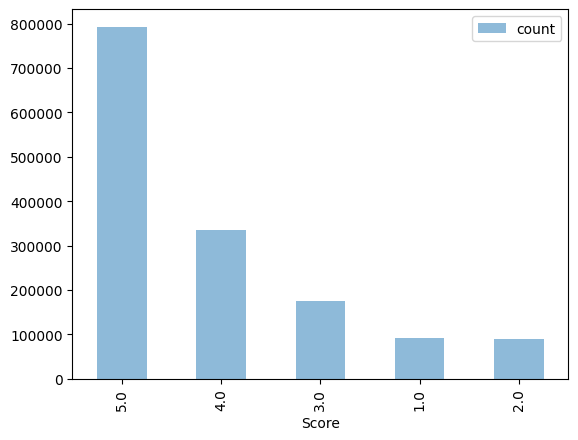


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [4]:
trainingSet = pd.read_csv("/Users/anneke/GitHub/abvo138-assignment-6/train.csv") 
testingSet = pd.read_csv("/Users/anneke/GitHub/abvo138-assignment-6/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Data Exploration

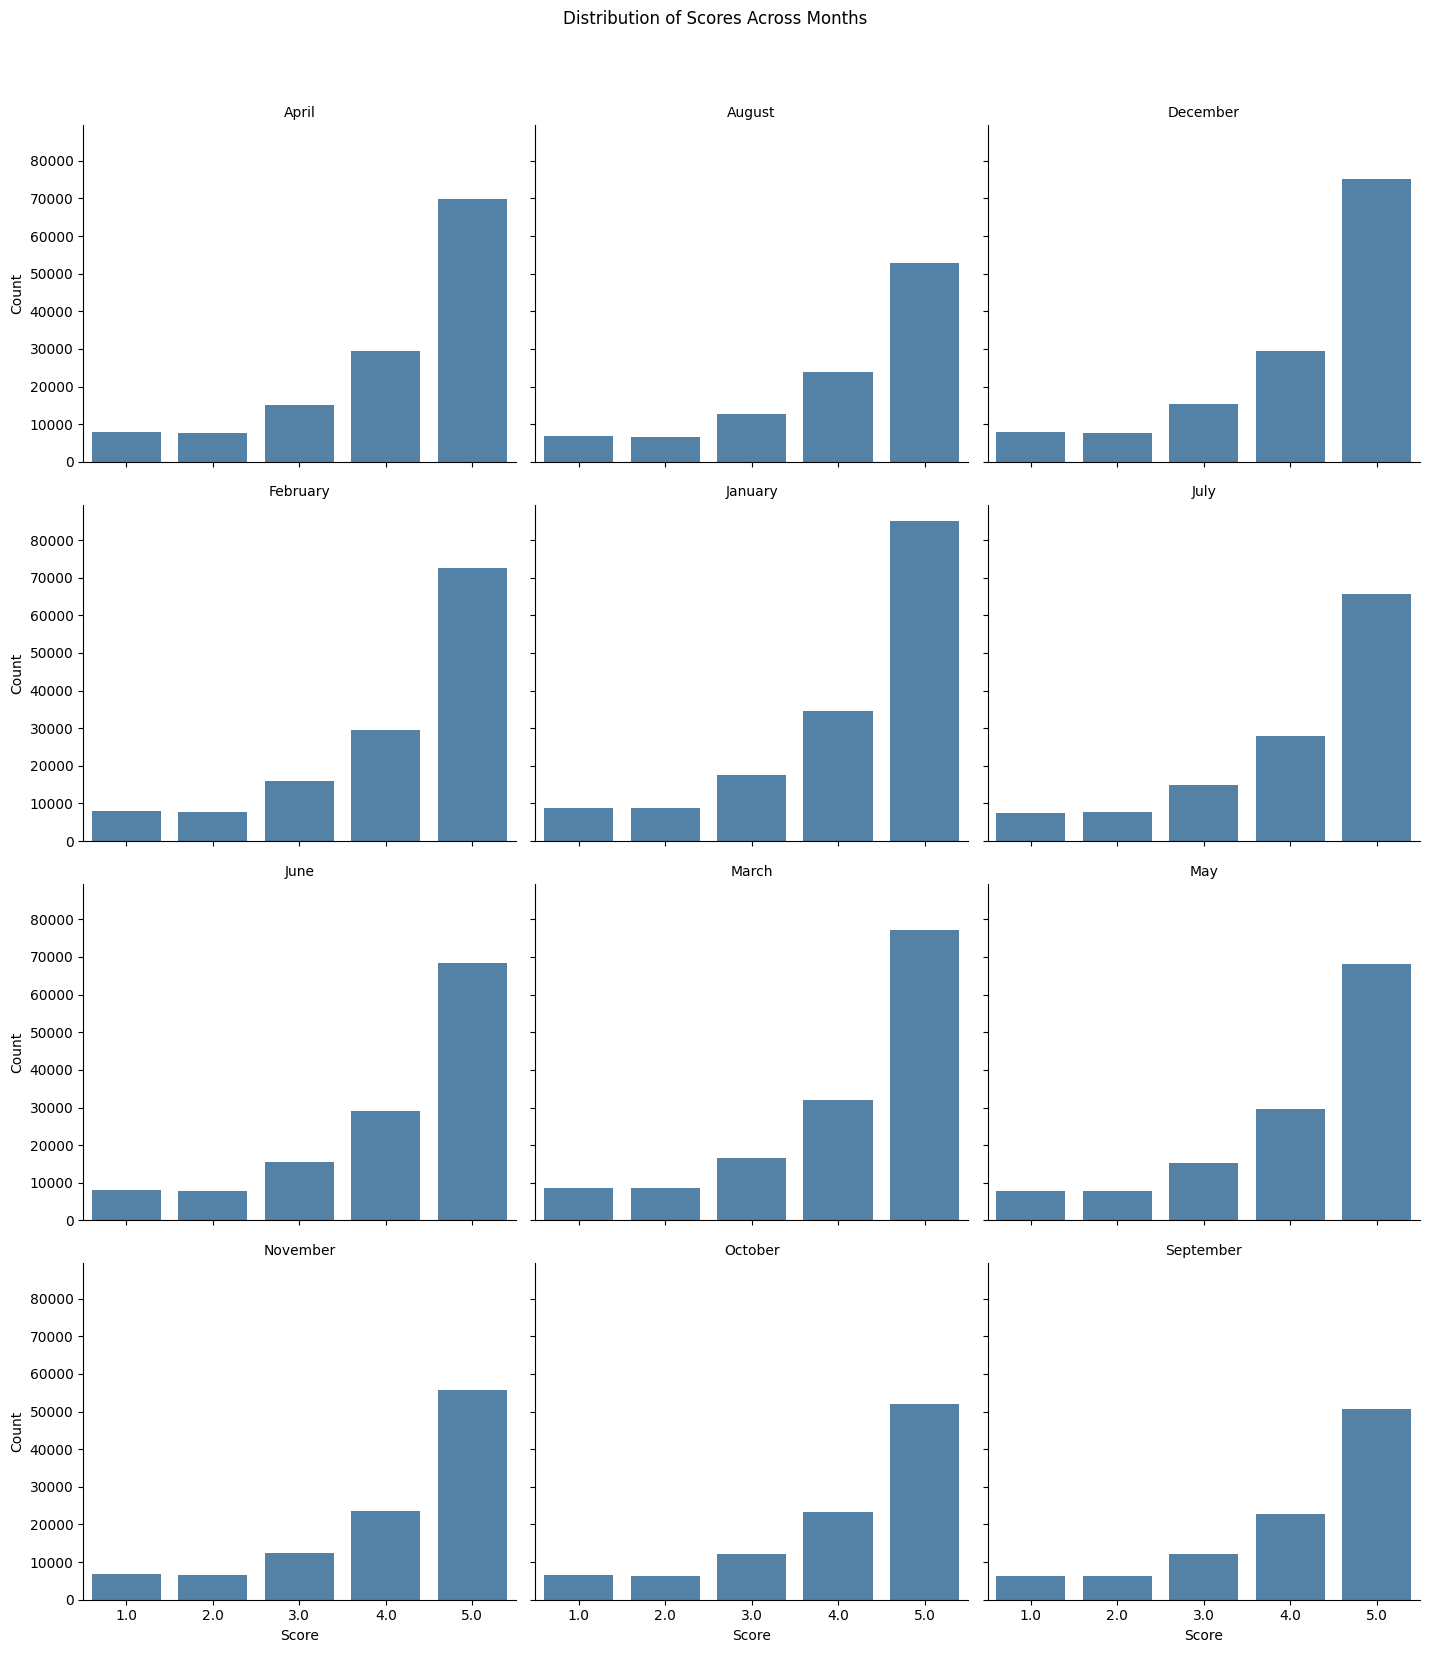

In [6]:
# Convert Unix timestamp to datetime and extract year and month
trainingSet['date'] = pd.to_datetime(trainingSet['Time'], unit='s')
trainingSet['month'] = trainingSet['date'].dt.strftime('%B')  # Full month name

# Group by month and score to count occurrences
df_count = trainingSet.groupby(['month', 'Score']).size().reset_index(name='count')

# Create a FacetGrid plot to facet by month
g = sns.FacetGrid(df_count, col='month', col_wrap=3, height=4, aspect=1.2)
g.map_dataframe(sns.barplot, x='Score', y='count', color='steelblue')

# Set the titles and labels
g.set_axis_labels("Score", "Count")
g.set_titles("{col_name}")
g.fig.suptitle('Distribution of Scores Across Months', y=1.03)

# Show the plot
plt.tight_layout()
plt.show()

# Adding Features

In [5]:
def add_features_to(df):
    # This is where you can do all your feature extraction

    # HELPFULNESS #############################
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0) # Helpfullness new feature

    df['Unhelpfulness'] = df['HelpfulnessDenominator'] - df['HelpfulnessNumerator']
    df['Unhelpfulness'] = df['Unhelpfulness'].fillna(0) # Helpfullness new feature

    # SUMMARY #################################
    # Term Frequency Inverse Document Frequency 
    vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed
    tfidf_matrix = vectorizer.fit_transform(df['Summary'].fillna(''))  # Handling any NaN text entries
    
    # Convert the TF-IDF matrix to a DataFrame
    summary_tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

    # Step 3: Concatenate the TF-IDF DataFrame with the original DataFrame
    df = pd.concat([df, summary_tfidf_df], axis=1)


    # TEXT ####################################
    # Term Frequency Inverse Document Frequency 
    vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed
    tfidf_matrix = vectorizer.fit_transform(df['Text'].fillna(''))  # Handling any NaN text entries
    
    # Convert the TF-IDF matrix to a DataFrame
    text_tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

    # Step 3: Concatenate the TF-IDF DataFrame with the original DataFrame
    df = pd.concat([df, text_tfidf_df], axis=1)

    # Count all special characters (excluding alphanumeric and whitespace)
    df['SpecialCharCount'] = df['Text'].apply(lambda x: len(re.findall(r'[^a-zA-Z0-9\s]', str(x))))
        
    # Step 4: Add a feature to count question marks
    df['QuestionMarkCount'] = df['Text'].apply(lambda x: str(x).count('?'))
    
    # Step 5: Add a feature to count exclamation marks
    df['ExclamationMarkCount'] = df['Text'].apply(lambda x: str(x).count('!'))

   
    # TIME ####################################
    df['Month'] = pd.to_datetime(df['Time']).dt.month  # Extracts month from the 'Time' column
    




# Could look at user bias - is a specific person more likely to review poitiviely or negatively 
# How many emojis, how many exclamation marks 

    return df

# Load the feature extracted files if they've already been generated
if exists('/Users/anneke/GitHub/abvo138-assignment-6/X_train.csv'):
    X_train = pd.read_csv("/Users/anneke/GitHub/abvo138-assignment-6/X_train.csv")
if exists('/Users/anneke/GitHub/abvo138-assignment-6/X_submission.csv'):
    X_submission = pd.read_csv("/Users/anneke/GitHub/abvo138-assignment-6/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("/Users/anneke/GitHub/abvo138-assignment-6/X_submission.csv", index=False) # the data that will be used for final submission
    X_train.to_csv("/Users/anneke/GitHub/abvo138-assignment-6/X_train.csv", index=False)

# Sample + Split into training and testing set

In [6]:
''' USE FOR SUBMISSIONS 
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)
'''

# Use for workshopping

# Step 1: Create a StratifiedShuffleSplit instance
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=10000, random_state=0)

# Step 2: Use the StratifiedShuffleSplit to maintain the score distribution
for train_index, test_index in stratified_split.split(X_train, X_train['Score']):
    X_train_sampled = X_train.iloc[test_index]  # Select 10,000 stratified rows

# Step 3: Split the sampled data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train_sampled.drop(columns=['Score']),  # Features
    X_train_sampled['Score'],                 # Labels
    test_size=1/4.0,                          # 25% test set
    random_state=0                            # Ensure reproducibility
)


# Can you add stratified CV here to help with the problem of unequal score distribution

# Feature Selection

In [7]:
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness']

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Model Creation

In [8]:
# Learn the model
model = KNeighborsClassifier(n_neighbors=3).fit(X_train_select, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test_select)

# Model Evaluation

Accuracy on testing set =  0.4075931232091691


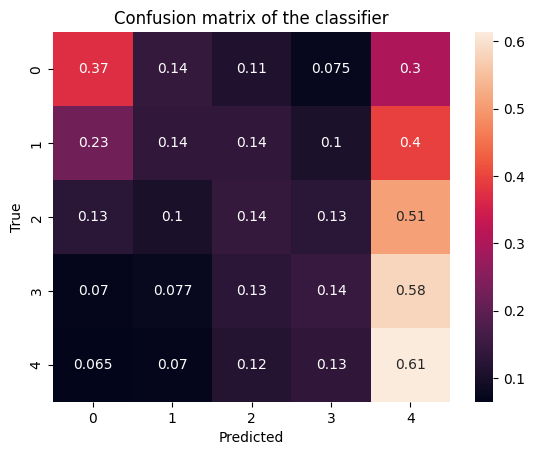

In [9]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Prof thinking that 70% accuracy is good

# Create submission file

In [10]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("/Users/anneke/GitHub/abvo138-assignment-6/submission.csv", index=False)